In [1]:
from typing import Optional, Tuple

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Iris dataset

The [Iris flower dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) is one of the "toy datasets" available in scikit-learn

In [2]:
def load_my_data(
        iris,
        *,
        target_name: str = "petal length (cm)",
        feature_name: Optional[str] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Extract target (y) and features (x)
    y_mask = np.array([n == target_name for n in iris.feature_names])
    iris_y = iris.data[:, y_mask].ravel()  # ravel: flatten the array to 1-dimension

    if feature_name is None:
        iris_X = iris.data[:, ~y_mask]
        feature_names = np.array(iris.feature_names)[~y_mask]
    else:
        x_mask = np.array([n == feature_name for n in iris.feature_names])
        iris_X = iris.data[:, x_mask]
        feature_names = np.array(iris.feature_names)[x_mask]

    return iris_X, iris_y, feature_names

We can import and display the dataset and its description like this:

In [3]:
iris = datasets.load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

# Regression: solve using ordinary least squares (OLS)

In [5]:
# Create linear regression object (model)
regr = LinearRegression()

## Simple regression

Petal length ~ Petal width

In [6]:
# Extract target (y) and features (x)
target_name = "petal length (cm)"
iris_X, iris_y, iris_features = load_my_data(
    iris,
    target_name=target_name,
    feature_name="petal width (cm)"
)

# Train the model using the data
regr.fit(iris_X, iris_y)

# Make predictions using the testing set
iris_y_pred = regr.predict(iris_X)

print(f"Coefficients:")
for name, coef in zip(iris_features, regr.coef_):
    print(f"{name}: {coef:.4f}")
print(f"Intercept: {regr.intercept_:.4f}")
# Mean squared error
print(f"Mean squared error: {mean_squared_error(iris_y, iris_y_pred):.4f}")

Coefficients:
petal width (cm): 2.2299
Intercept: 1.0836
Mean squared error: 0.2256


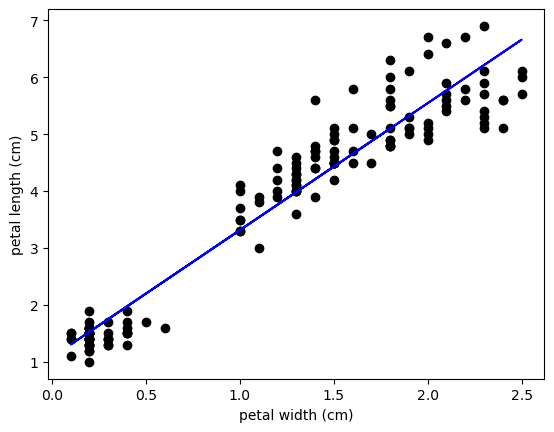

In [7]:
# Plot outputs
df_plt = pd.DataFrame(
    {
        "x": iris_X.ravel(),
        "y": iris_y,
        "y_pred": iris_y_pred,
    }
)
plt.scatter(df_plt["x"], df_plt["y"], color="black")
plt.plot(df_plt["x"], df_plt["y_pred"], "b")
plt.xlabel(iris_features[0])
plt.ylabel(target_name)
plt.show()

## Multiple regression

Petal length ~ Petal width + Sepal length + Sepal width

In [8]:
# Extract target (y) and features (x)
target_name = "petal length (cm)"
iris_X, iris_y, iris_features = load_my_data(
    iris,
    target_name=target_name,
)
iris_y.shape, iris_X.shape

((150,), (150, 3))

In [9]:
# Train the model using the data
regr.fit(iris_X, iris_y)

# Make predictions using the testing set
iris_y_pred = regr.predict(iris_X)

# Access coefficients
print(f"Coefficients: \n")
for name, coef in zip(iris_features, regr.coef_):
    print(f"{name}: {coef:.4f}")
print(f"Intercept: {regr.intercept_:.4f}")
# Mean squared error
print("\n")
print(f"Mean squared error: {mean_squared_error(iris_y, iris_y_pred):.4f}")

Coefficients: 

sepal length (cm): 0.7291
sepal width (cm): -0.6460
petal width (cm): 1.4468
Intercept: -0.2627


Mean squared error: 0.0990


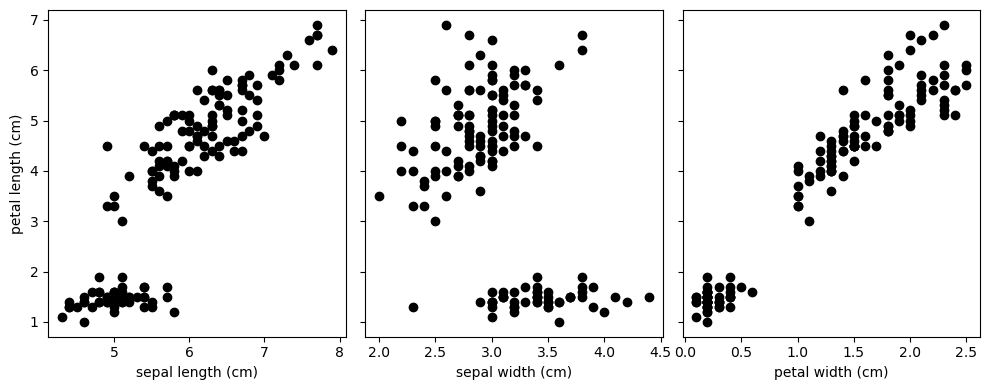

In [10]:
# Plot outputs
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

# Plot data on each subplot
for i, n in enumerate(iris_features):
    axs[i].scatter(iris_X[:, i], iris_y, color="black")
    axs[i].set_xlabel(iris_features[i])
axs[0].set_ylabel(target_name)

fig.tight_layout()
plt.show()

# Gradient descent

In [11]:
def _plt_loss(loss, xmax, xlab="iteration", val_loss=None):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(loss, "bo")
    if val_loss is not None:
        ax.plot(val_loss, "ro", alpha=0.5)
    ax.set_xlim(-0.1, xmax)
    ax.set_xlabel(xlab)
    ax.set_ylabel("loss")
    ax.grid(True)
    plt.show()


def _plt_loss_params(df_data, loss, xmax):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(loss, "bo")
    ax[0].set_xlim(-0.1, xmax)
    ax[0].set_xlabel("iteration")
    ax[0].set_ylabel("loss")
    ax[0].grid(True)

    ax[1].plot(df_data["x"], df_data["y"], "ko")
    ax[1].plot(df_data["x"], df_data["y_pred"], "b")
    ax[1].set_xlabel("feature")
    ax[1].set_ylabel("target")
    plt.show()



def gradient_descent_regression(
    features: np.ndarray,
    target: np.ndarray,
    *,
    learning_rate: float = 0.01,
    n_iter: int = 100,
    seed: int = 42,
    plot: bool = True,
) -> Tuple[np.ndarray, float, np.ndarray]:
    """
    Find optimal weights and bias for linear regression task

    Parameters
    ----------
    features : numpy array of shape (n, p)
    target : numpy array of shape (n,)
    learning_rate : learning rate to control the update step size
    n_iter : number of iterations
    seed : seed for reproducibility
    plot : plot gradient descent progress 

    Returns
    -------
    tuple containing the learned weights, bias and loss across iterations
    """
    np.random.seed(seed)
    # Initialize weights and bias with random values
    n, p = features.shape
    weights = np.random.rand(p)
    bias = np.random.rand(1)

    loss = np.zeros(n_iter)
    if p == 1 and plot:
        df_data = pd.DataFrame(
            {
                "x": features.ravel(),
                "y": target,
                "y_pred": np.zeros(target.shape[0]),
            }
        )
    
    # Loop for the number of iterations
    for i in range(n_iter):
        # Predict target values using current weights and bias
        predicted = np.dot(features, weights) + bias

        # Calculate the error (to be used in the gradient, see below)
        error = target - predicted
        loss[i] = np.mean(error ** 2)

        if plot:
            # Update plot dynamically
            if p == 1:
                df_data["y_pred"] = predicted
                _plt_loss_params(df_data, loss[:i], n_iter)
            else:
                _plt_loss(loss[:i], n_iter)

        # Calculate partial derivatives for weights and bias
        weights_gradient = -2/n * np.dot(features.T, error)
        bias_gradient = -2/n * np.sum(error)

        # Update weights and bias using learning rate
        weights -= learning_rate * weights_gradient
        bias -= learning_rate * bias_gradient

    print("Learned weights: ", weights)
    print("Learned bias", bias)
    print("Loss:", loss[-1])
    return weights, bias, loss

## Simple regression

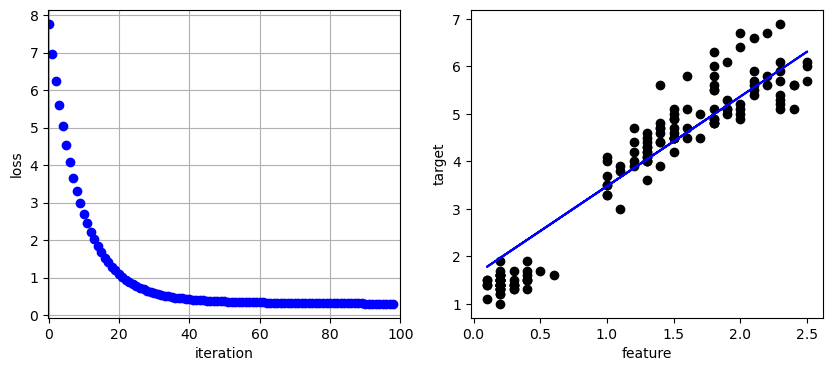

Learned weights:  [1.89127711]
Learned bias [1.5856846]
Loss: 0.3016635610962177


In [12]:
# Extract target (y) and features (x)
target_name = "petal length (cm)"
iris_X, iris_y, iris_features = load_my_data(
    iris,
    target_name=target_name,
    feature_name="petal width (cm)"
)

weights, bias, loss = gradient_descent_regression(iris_X, iris_y)

The current loss exceeds that achieved with OLS. Therefore, let's experiment with a higher learning rate to accelerate convergence. I also change the seed to modify the initialization

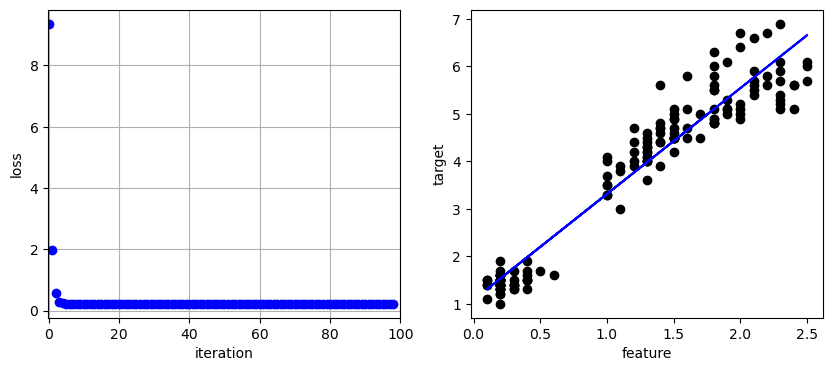

Learned weights:  [2.23060986]
Learned bias [1.08254775]
Loss: 0.22563201581038222


In [13]:
weights, bias, loss = gradient_descent_regression(iris_X, iris_y, seed=10, learning_rate=0.1)

Results using ordinary least squares

- petal width (cm): 2.2299
- Intercept: 1.0836
- Mean squared error: 0.2256

## Multiple regression

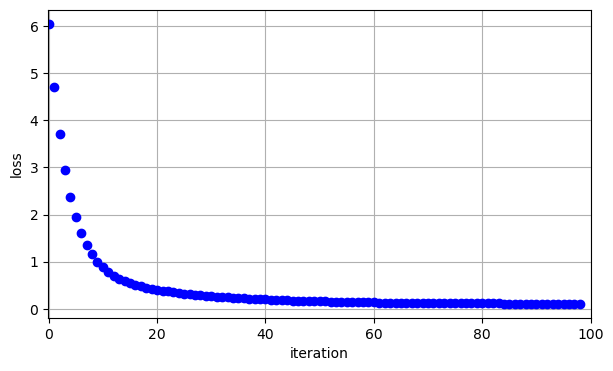

Learned weights:  [ 0.65920294 -0.75788154  1.3909446 ]
Learned bias [0.56631225]
Loss: 0.10867655441467686


In [14]:
# Extract target (y) and features (x)
target_name = "petal length (cm)"
iris_X, iris_y, iris_features = load_my_data(
    iris,
    target_name=target_name,
)

weights, bias, loss = gradient_descent_regression(iris_X, iris_y, seed=10, learning_rate=0.02)

Results using ordinary  least squares:
- sepal length (cm): 0.7291
- sepal width (cm): -0.6460
- petal width (cm): 1.4468
- Intercept: -0.2627
- Mean squared error: 0.0990

In [15]:
# Strategy 1: increase number of iterations
weights, bias, loss = gradient_descent_regression(iris_X, iris_y, seed=10, learning_rate=0.02, plot=False, n_iter=20000)

Learned weights:  [ 0.72883595 -0.64623601  1.44698335]
Learned bias [-0.26047126]
Loss: 0.0990196916603475


In [16]:
# Strategy 2: standardize features
scaler = preprocessing.StandardScaler().fit(iris_X)
iris_X_scaled = scaler.transform(iris_X)
weights, bias, loss = gradient_descent_regression(iris_X_scaled, iris_y, seed=10, learning_rate=0.02, plot=False, n_iter=2000)

# Transform coefficients back to original scale
weights_orig = weights / scaler.scale_
bias_orig = bias - np.dot(scaler.mean_, weights / scaler.scale_)

print("Learned weights: ", weights_orig)
print("Learned bias", bias_orig)

Learned weights:  [ 0.60176155 -0.28063576  1.09911539]
Learned bias [3.758]
Loss: 0.09901965315376463
Learned weights:  [ 0.72914166 -0.64601446  1.44678959]
Learned bias [-0.26271921]


We observe that:
- The initial weights chosen for the gradient descent algorithm play a role in determining the eventual solution. We can change the initialization by modifying the seed
- The learning rate is pivotal in achieving convergence


# Stochastic gradient descent

In [17]:
def sgd_regression(
    features: np.ndarray,
    target: np.ndarray,
    *,
    learning_rate: float = 0.01,
    epochs: int = 1000,
    batch_size: int = 30,
    seed: int = 42,
    plot: bool = True,
) -> Tuple[np.ndarray, float, float]:
    """
    Perform Stochastic Gradient Descent with minibatches to fit a linear model
    
    Parameters
    ----------
    features: input feature matrix (shape: [num_samples, num_features])
    target: target values (shape: [num_samples])
    learning_rate: learning rate for gradient descent
    epochs: number of epochs for training
    batch_size: size of the minibatches
    seed : seed for reproducibility
    plot : plot gradient descent progress 
    
    Returns
    -------
    tuple containing the learned weights (shape: [num_features]), bias and loss
    """
    np.random.seed(seed)
    # Initialize weights and bias with random values
    n, p = features.shape
    weights = np.random.rand(p)
    bias = np.random.rand(1)

    loss = []
    for epoch in range(epochs):
        # Shuffle the data
        permutation = np.random.permutation(n)
        X_shuffled = features[permutation]
        y_shuffled = target[permutation]

        # Create minibatches
        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Compute predictions
            # Predict target values using current weights and bias
            y_pred = np.dot(X_batch, weights) + bias

            # Compute gradients
            error = y_batch - y_pred
            weights_gradient = -(2 / batch_size) * np.dot(X_batch.T, error)
            bias_gradient = -(2 / batch_size) * np.sum(error)

            # Update parameters
            weights -= learning_rate * weights_gradient
            bias -= learning_rate * bias_gradient

        # Compute and record the loss for this epoch
        y_pred_full = np.dot(features, weights) + bias
        loss.append(np.mean((target - y_pred_full)**2))

        # Print the loss every 100 epochs        
        if epoch % 100 == 0:
            if plot:
                # Update plot dynamically
                _plt_loss(loss, epochs, "epoch")
            else:
                print(f"Epoch {epoch}, Loss: {loss[-1]}")

    print("Learned weights: ", weights)
    print("Learned bias", bias)
    print("Loss:", loss[-1])
    return weights, bias, loss[-1]

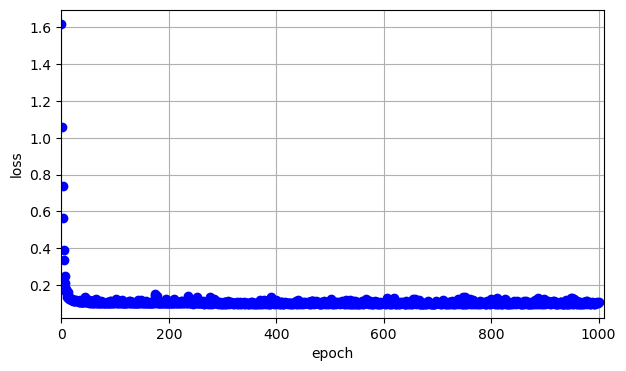

Learned weights:  [ 0.72031875 -0.65752616  1.45279673]
Learned bias [-0.19307017]
Loss: 0.09917023329571675


In [18]:
# Extract target (y) and features (x)
target_name = "petal length (cm)"
iris_X, iris_y, iris_features = load_my_data(
    iris,
    target_name=target_name,
)

weights, bias, loss = sgd_regression(iris_X, iris_y, learning_rate=0.001, batch_size=1, epochs=1010)

Scikit-learn implements this algorithm cleverly. However, even for this straightforward example, optimizing the learning rate hyperparameters requires careful tuning to enhance performance

In [19]:
# Initialize SGDRegressor
sgd_regr = SGDRegressor(loss="squared_error", penalty=None, max_iter=1010, random_state=42)

# Standardize features
scaler = preprocessing.StandardScaler()
iris_X_scaled = scaler.fit_transform(iris_X)

# Fit the model
sgd_regr.fit(iris_X_scaled, iris_y)

iris_y_pred = sgd_regr.predict(iris_X_scaled)
# Access coefficients
print(f"Coefficients: \n")
for name, coef in zip(iris_features, sgd_regr.coef_):
    print(f"{name}: {coef:.4f}")
print(f"Intercept: {sgd_regr.intercept_[0]:.4f}")
# Mean squared error
print("\n")
print(f"Mean squared error: {mean_squared_error(iris_y, iris_y_pred):.4f}")

Coefficients: 

sepal length (cm): 0.6992
sepal width (cm): -0.3109
petal width (cm): 0.9916
Intercept: 3.7382


Mean squared error: 0.1026


# Training / test splits

We will employ training/test splits to demonstrate how to effectively fine-tune the learning rate in our implementation of SGD and look at some "real" learning curves

In [20]:
def sgd_splits(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    *,
    learning_rate: float = 0.01,
    epochs: int = 1000,
    batch_size: int = 30,
    seed: int = 42,
    plot: bool = True,
) -> Tuple[np.ndarray, float, float, float]:
    """
    Perform Stochastic Gradient Descent with minibatches to fit a linear model
    
    Parameters
    ----------
    X_train : input feature matrix for training (shape: [num_train_samples, num_features])
    y_train : target values for training (shape: [num_train_samples])
    X_val : input feature matrix for validation (shape: [num_val_samples, num_features])
    y_val : target values for validation (shape: [num_val_samples])
    learning_rate: learning rate for gradient descent
    epochs: number of epochs for training
    batch_size: size of the minibatches
    seed : seed for reproducibility
    plot : plot gradient descent progress 
    
    Returns
    -------
    tuple containing the learned weights (shape: [num_features]), bias, training and validation losses
    """

    np.random.seed(seed)
    # Initialize weights and bias with random values
    n_train_samples, p = X_train.shape
    weights = np.random.rand(p)
    bias = np.random.rand(1)
    
    train_loss = np.zeros(epochs)
    val_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        # Shuffle the training data
        permutation = np.random.permutation(n_train_samples)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        
        # Create minibatches
        for i in range(0, n_train_samples, batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            
            # Compute predictions
            y_pred = np.dot(X_batch, weights) + bias
            
            # Compute gradients
            error = y_batch - y_pred
            weights_gradient = -(2 / batch_size) * np.dot(X_batch.T, error)
            bias_gradient = -(2 / batch_size) * np.sum(error)
            
            # Update parameters
            weights -= learning_rate * weights_gradient
            bias -= learning_rate * bias_gradient
        
        # Compute and record the training loss for this epoch
        y_train_pred_full = np.dot(X_train, weights) + bias
        train_loss[epoch] = np.mean((y_train - y_train_pred_full)**2)
        
        # Compute and record the validation loss for this epoch
        y_val_pred_full = np.dot(X_val, weights) + bias
        val_loss[epoch] = np.mean((y_val - y_val_pred_full)**2)
        
        # Print the loss every 100 epochs
        if epoch % 100 == 0:
            
            if plot:
                # Update plot dynamically
                _plt_loss(train_loss[:epoch], epochs, "epoch", val_loss=val_loss[:epoch])
            else:
                print(f"Epoch {epoch}, Training Loss: {train_loss[epoch]}, Validation Loss: {val_loss[epoch]}")

    print("Learned weights: ", weights)
    print("Learned bias", bias)
    print("Training loss:", train_loss[-1])
    print("Validation loss:", val_loss[-1])

    return weights, bias, train_loss, val_loss

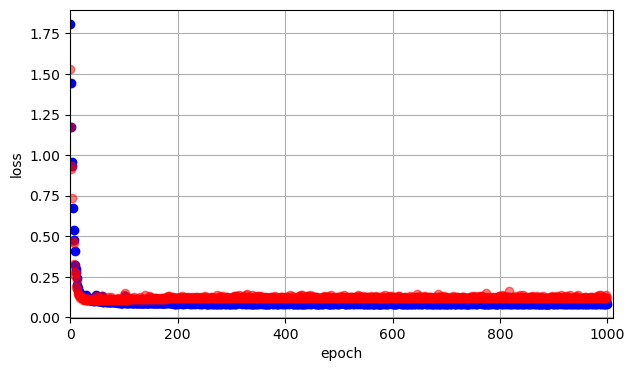

Learned weights:  [ 0.76502904 -0.77836708  1.41736821]
Learned bias [0.08914427]
Training loss: 0.09316950655471117
Validation loss: 0.12968710704072997


In [21]:
# Extract target (y) and features (x)
target_name = "petal length (cm)"
iris_X, iris_y, iris_features = load_my_data(
    iris,
    target_name=target_name,
)

X_train, X_test, y_train, y_test = train_test_split(
    iris_X,
    iris_y,
    test_size=0.2,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.33,
    random_state=42,
)
weights, bias, train_loss, val_loss = sgd_splits(
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=1010,
    batch_size=1,
    learning_rate=0.001,
)

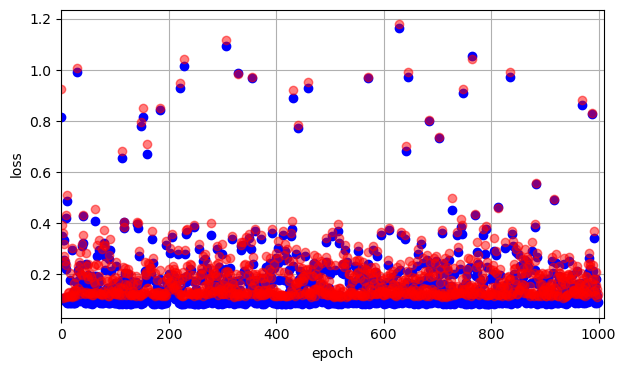

Learned weights:  [ 0.74844783 -0.74342905  1.39779084]
Learned bias [-0.11430402]
Training loss: 0.09816722752216636
Validation loss: 0.12541075576276667


In [22]:
weights, bias, train_loss, val_loss_01 = sgd_splits(
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=1010,
    batch_size=1,
    learning_rate=0.01,
) #  1-fold x-validation

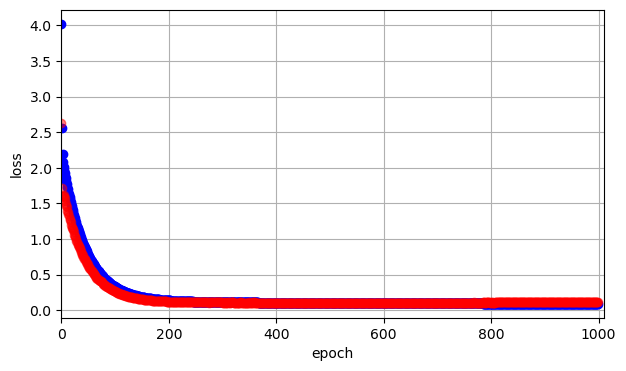

Learned weights:  [ 0.60933504 -0.66256782  1.58031035]
Learned bias [0.34965654]
Training loss: 0.08938807121485708
Validation loss: 0.10850614680445311


In [23]:
weights, bias, train_loss, val_loss_0001 = sgd_splits(
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=1010,
    batch_size=1,
    learning_rate=0.0001,
)

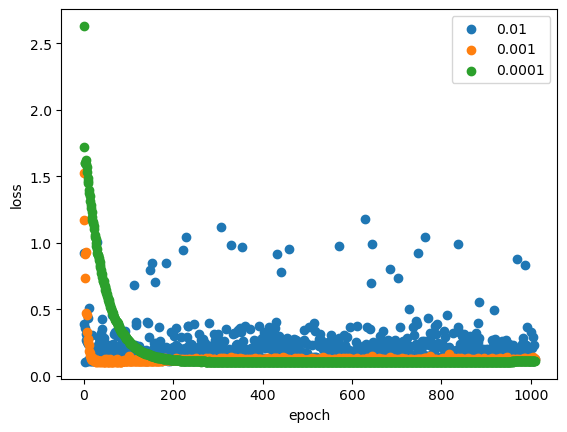

In [24]:
plt.scatter(np.arange(val_loss.shape[0]), val_loss_01, label="0.01")
plt.scatter(np.arange(val_loss.shape[0]), val_loss, label="0.001")
plt.scatter(np.arange(val_loss.shape[0]), val_loss_0001, label="0.0001")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.show()